In [1]:
##5月6号
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import math
import os
from shapely.geometry import Point,Polygon,shape
from shapely.geometry import LineString
##全显示不折叠，非常耗内存，非特殊情况不要生效
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

In [2]:
##合并老卡和新卡的6号的数据
allshuka=pd.concat(map(pd.read_csv,[r'D:\项目\扬州\公交刷卡数据\老卡时间修正5月13号.csv',r'D:\项目\扬州\公交刷卡数据\新卡不必时间修正5月13日.csv']))
allshuka.to_csv(r'D:\项目\扬州\公交刷卡数据\新旧卡所有刷卡5月13日.csv')  
allshuka

,Unnamed: 0,CHEID,日期,时间
0,0,4879.0,20210513,10:45:30
1,1,4879.0,20210513,10:51:13
2,2,4879.0,20210513,11:1:29
3,3,4879.0,20210513,11:4:8
4,4,4879.0,20210513,11:10:17
...,...,...,...,...
96839,96839,4152.0,20210513,17:48:19
96840,96840,4152.0,20210513,18:19:48
96841,96841,4152.0,20210513,17:13:19
96842,96842,4152.0,20210513,17:13:18


In [3]:
#allshuka=pd.read_csv(r'D:\项目\扬州\公交刷卡数据\新旧卡所有刷卡5月6日.csv')
allshuka.时间 = allshuka.时间 .apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                allshuka.时间 .apply(lambda r:r.split(':')[1]).astype('int')*60+\
               allshuka.时间 .apply(lambda r:r.split(':')[2]).astype('int')
#allshuka

In [4]:
allshuka

,Unnamed: 0,CHEID,日期,时间
0,0,4879.0,20210513,38730
1,1,4879.0,20210513,39073
2,2,4879.0,20210513,39689
3,3,4879.0,20210513,39848
4,4,4879.0,20210513,40217
...,...,...,...,...
96839,96839,4152.0,20210513,64099
96840,96840,4152.0,20210513,65988
96841,96841,4152.0,20210513,61999
96842,96842,4152.0,20210513,61998


In [5]:
allxianlu=pd.read_excel(r'F:\扬州公交GPS数据\ic线路对应2021-11-25.xls')
allxianlu

,序号,IC线路号,线路id,线路名称,说明,5月6日匹配结果（车次编号*趟数）,上行方向
0,3,10,1001,1路,NaN,19*8,东向西
1,4,20,1002,2路,NaN,NaN,北向南
2,5,30,1003,3路,NaN,NaN,NaN
3,6,50,1005,5路,NaN,NaN,北向南
4,7,60,1006,6路,NaN,NaN,北向南
...,...,...,...,...,...,...,...
207,158,9980,3088,K1路,NaN,NaN,NaN
208,161,883,3088,K1路,NaN,NaN,NaN
209,203,9880,3088,K1路,NaN,NaN,NaN
210,204,1032,3103,103区间车,NaN,NaN,NaN


In [47]:
xianluid=1340

In [48]:
allxianlu2=allxianlu.loc[allxianlu.线路id==xianluid]
allxianlu2

,序号,IC线路号,线路id,线路名称,说明,5月6日匹配结果（车次编号*趟数）,上行方向
149,148,3400,1340,340路,NaN,NaN,NaN


In [ ]:
#读取线路的shp文件
shp = r'D:\项目\扬州\公交线路\公交线路\公交线路（地理坐标）.shp'
xianlu= geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
###line数据预处理
xianlu = gpd.GeoDataFrame(xianlu)##转换为一个GeoDataFrame
###GeoDataFrame坐标转换
xianlu.crs = {'init':'epsg:4326'}
xianlu = xianlu.to_crs(epsg = 2416)
xianlu###至此线路数据预处理完毕
lineshp=xianlu.loc[xianlu.ROUTEID=='60路晚']###这种索引方式更舒适一些
lineshp=lineshp['geometry'].iloc[0]
lineshp

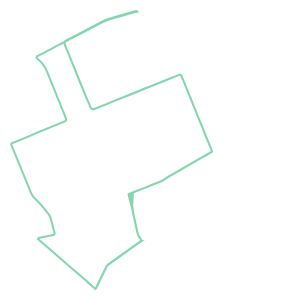

In [49]:
##若轨迹不连续，则读取一辆车的单趟轨迹作为lineshp，如果含往返会出问题
line=pd.read_csv(r'F:\扬州公交GPS数据\扬州公交\line_5_6\线路shp\\'+str(xianluid)+'_line.csv')
#生成线要素
from shapely.geometry import LineString
dianlon=line['LONGITUDE']
dianlat=line['LATITUDE']
dianlist=[]
for i in range(0,len(line)):
    g=(dianlon[i],dianlat[i])
    dianlist.append(g)
    pass
dianlist
linestr = LineString(dianlist)
line['geometry']=linestr
line = gpd.GeoDataFrame(line)
line.crs = {'init':'epsg:4326'}
line=line.to_crs(epsg = 2416)
lineshp=line['geometry'].iloc[0]
lineshp

In [50]:
for idid in [xianluid]:
    routeid=idid
    yichang=0
    ####读取同一条线路上的车
    import glob
    ##母文件夹地址和文件类型
    files=glob.glob(r'D:\项目\扬州\BUSGPS\车辆编号带线路编号///*'+'_'+str(routeid)+'.csv')###!!!!
    ##需要读取的列
    #cols=['ROUTEID']
    ##列表推导出对象
    #dflist=[pd.read_csv(i,usecols=cols) for i in files]
    files = gpd.GeoDataFrame(files)#
    #print(files )
    files.columns=['文件']
    files['文件']= files['文件'].astype(str)
    for i in range(0,len(files)):
        files.at[i,'文件']=str(files.at[i,'文件']).replace('\\','B')
        files.at[i,'文件']=str(files.at[i,'文件']).replace(r'D:B项目B扬州BBUSGPSB车辆编号带线路编号B','')
        files.at[i,'文件']=str(files.at[i,'文件']).replace(r'_'+str(routeid)+'.csv','')##前面后面分开替换成无，注意要用r和双斜杠
    ##匹配上下客人数
    #cheid3=cheid2
    ##根据图形，选择cheid2
    for cheid in files['文件']:
        #读取GPS数据
        BUS_GPS= pd.read_csv(r'D:\项目\扬州\BUSGPS\车辆编号带线路编号\\'+str(cheid)+'_'+str(routeid)+'.csv',header = None)
        #print('len(BUS_GPS)')
        #print(len(BUS_GPS))
        if len(BUS_GPS)>1000:
            ##提取有用BUS_GPS
            BUS_GPS.columns=BUS_GPS.iloc[0]
            BUS_GPS=BUS_GPS[BUS_GPS['???"BUSRDID"']!='???"BUSRDID"']
            BUS_GPS=BUS_GPS[[ '???"BUSRDID"', 'ROUTEID', 'PRODUCTID', 'ACTDATETIME', 'BUSSID', 'LONGITUDE', 'LATITUDE']]
            ###切分字符串，对BUS_GPS进行进一步处理
            #print(BUS_GPS)
            BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/12']
            BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/13']
            BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/14']
            BUS_GPS['日期'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[0])
            BUS_GPS['时间'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[1])
            BUS_GPS=BUS_GPS.loc[BUS_GPS.日期=='2021/5/13']
            if len(BUS_GPS)>100:
                ##切分bus_gps的车辆编号
                BUS_GPS['PRODUCTID']= BUS_GPS['PRODUCTID'].astype(str)
                BUS_GPS['carid'] = BUS_GPS['PRODUCTID'].apply(lambda r:r.split('5140')[1])
                BUS_GPS['time_st'] = BUS_GPS['时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                                BUS_GPS['时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                                BUS_GPS['时间'].apply(lambda r:r.split(':')[2]).astype('int')
                BUS_GPS.sort_values(by='time_st',inplace=True)
                ##BUS_GPS[BUS_GPS['BUSSID']=='4.0']观察数据，bussid 4下行5上行6环形
                ###生成BUS_GPS的点要素
                #对公交GPS点生成点要素，并转换为一个GeoDataFrame，方便后续的地图匹配
                BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']]= BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']].apply(pd.to_numeric)###字符串转换为数值
                BUS_GPS['geometry'] = BUS_GPS.apply(lambda r:Point(r['LONGITUDE'],r['LATITUDE']),axis = 1)
                BUS_GPS = gpd.GeoDataFrame(BUS_GPS)##转换为一个GeoDataFrame
                BUS_GPS
                xianluid=BUS_GPS['ROUTEID'].iloc[0]
                #print('xianluid')
                #print(xianluid)
                ##GeoDataFrame坐标转换
                BUS_GPS.crs = {'init':'epsg:4326'}
                BUS_GPS = BUS_GPS.to_crs(epsg = 2416)
                BUS_GPS###至此公交车数据预处理完毕
                ###清除飘零点
                BUS_GPS=BUS_GPS[(BUS_GPS['LONGITUDE']!=0)&(BUS_GPS['LATITUDE']!=0)]
                if len(BUS_GPS)>1000:
                    #地图匹配
                    BUS_GPS['project'] = BUS_GPS['geometry'].apply(lambda r:lineshp.project(r))
                    #原始的坐标点存储在一个字段中
                    BUS_GPS['geometry_orgin'] = BUS_GPS['geometry']
                    #生成匹配的坐标点
                    BUS_GPS['geometry'] = BUS_GPS['project'].apply(lambda r:lineshp.interpolate(r))
                    #批量计算原始点和匹配点之间的距离
                    BUS_GPS['diff'] = BUS_GPS.apply(lambda r:r['geometry_orgin'].distance(r['geometry']),axis = 1)
                    ##轨迹点偏移shp400米以外，则删除
                    BUS_GPS=BUS_GPS[BUS_GPS['diff']<400]
                    if len(BUS_GPS)>1000:
                        ###区别车辆的上下行
                        #对车辆重新编号
                        BUS_GPS=BUS_GPS.loc[(BUS_GPS.BUSSID=='4.0')|(BUS_GPS.BUSSID=='5.0')|(BUS_GPS.BUSSID=='6.0')]
                        BUS_GPS['BUSSID1'] = BUS_GPS['BUSSID'].shift()
                        #此时两个条件：方向发生了改变或者本来这一条记录就是新车
                        BUS_GPS['flag'] = BUS_GPS['BUSSID1']!=BUS_GPS['BUSSID']
                        BUS_GPS['changedir'] = BUS_GPS['flag'].cumsum()
                        #提取有用的信息列
                        BUS_project = BUS_GPS[['carid','changedir','time_st','project','BUSSID']]
                        BUS_project = BUS_project.drop_duplicates()
                        #print(BUS_project)
                            ##提取线路上的站点
                        allstop=gpd.read_file(r'D:\项目\扬州\BUSGPS\ROUTESTATION.csv',encoding = 'utf-8')
                        mytest=allstop.loc[allstop.ROUTEID==str(xianluid)]
                        mytest=mytest.filter(items=['???RSEGMENTSID', 'ROUTEID', 'SEGMENTID', 'STATIONID',
                               'SNGSERIALID', 'STATIONTYPEID', 'STATIONTYPENAME', 'DUALSERIALID', 'STATIONNAME'])
                        mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']]= mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']].apply(pd.to_numeric)
                        mytest.sort_values(by=['SEGMENTID','SNGSERIALID','DUALSERIALID'],inplace=True)##要转化数据格式，不然是按照字符串正则排序
                        stations=mytest['STATIONID']
                        ##获取站点的具体信息
                        STATION= gpd.read_file(r'D:\项目\扬州\BUSGPS\STATION.csv',encoding = 'utf-8')
                        test=STATION.filter(items=['???STATIONID', 'STATIONNO', 'STATIONNAME', 'STATIONTYPE',
                               'STATIONTYPENAME', 'ROADNAME', 'LONGITUDE','LATITUDE'])
                        mystation=test[test['???STATIONID'].isin(stations)]
                        ##合并信息
                        st=mytest.merge(mystation,how='outer',left_on='STATIONID',right_on='???STATIONID',left_index=False,right_index=False,sort=False,suffixes=('_linestation', '_station'),copy=True,indicator=False,validate=None)
                        ##生成站点的点要素
                        stop=st[['ROUTEID', 'SEGMENTID', 'STATIONID', 'SNGSERIALID', 'STATIONTYPEID',  'DUALSERIALID','STATIONNAME_linestation', 'STATIONNO',
                         'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']]
                        stop.columns=['ROUTEID', '上下行标记', 'STATIONID', '单程站序', 'STATIONTYPEID',  '往返站序','STATIONNAME', 'STATIONNO',
                         'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']
                        stop[['LONGITUDE','LATITUDE']]= stop[['LONGITUDE','LATITUDE']].apply(pd.to_numeric)###字符串转换为数值
                        #print(stop)
                        stop=stop.dropna()
                        stop['geometry'] = stop.apply(lambda r:Point(r['LONGITUDE'],r['LATITUDE']),axis = 1)
                        stop = gpd.GeoDataFrame(stop)##转换为一个GeoDataFrame
                        ###GeoDataFrame坐标转换
                        stop.crs = {'init':'epsg:4326'}
                        stop = stop.to_crs(epsg = 2416)
                        stop=stop[(stop['LONGITUDE']!=0)&(stop['LATITUDE']!=0)]
                        #print(stop)
                        ###至此站点数据预处理完毕
                        #标记站点位置
                        #地图匹配
                        stop['project'] = stop['geometry'].apply(lambda r:lineshp.project(r))
                        #stop = stop[stop['linename'] == linename]
                        ##上行到离站识别
                        #stop=stopall.loc[stopall.上下行标记==sxzhandian[0]]
                        #BUS_project=BUS_projectall.loc[(BUS_projectall.BUSSID!='5.0')|(BUS_projectall.BUSSID!='5')]
                        ##到离站时间识别
                        #定义时间阈值
                        mintime =10*60
                        from shapely.geometry import LineString,Polygon
                        import shapely
                        #定义一个空的list存储识别结果
                        ls = []
                        #对每一辆车识别
                        for car in BUS_project['carid'].drop_duplicates():
                            #提取车辆轨迹
                            tmp = BUS_project[BUS_project['carid'] == car]
                            #print('tmp')
                            #print(tmp)
                            #对每一个站点识别
                            for stopid in stop['STATIONNO'].drop_duplicates():
                                try:
                                    ##提取站点名称
                                    stopname = stop[stop['STATIONNO'] == stopid]['STATIONNAME'].iloc[0]
                                    #提取站点位置
                                    position = stop[stop['STATIONNO'] == stopid]['project'].iloc[0]
                                    #做buffer缓冲区
                                    stopbuffer = 800
                                    #生成一个buffer的polygon
                                    buffer_polygon = LineString([[0,position],[24*3600,position]]).buffer(stopbuffer)
                                    #生成车辆轨迹的linestring
                                    bus_linestring = LineString(tmp[['time_st','project']].values)
                                    #提取车辆轨迹与buffer的交集
                                    line_intersection = bus_linestring.intersection(buffer_polygon)
                                    #从multilinestring中提取其中的到离站轨迹
                                    if type(line_intersection) == shapely.geometry.linestring.LineString:
                                        arrive = [line_intersection]
                                    else:
                                        arrive = list(line_intersection)
                                    arrive = pd.DataFrame(arrive)
                                    #取其中的到离站信息
                                    arrive['arrivetime']= arrive[0].apply(lambda r:r.coords[0][0])
                                    arrive['leavetime']= arrive[0].apply(lambda r:r.coords[-1][0])
                                    #print(arrive)
                                    #通过时间阈值筛选到离站信息
                                    a = arrive[['arrivetime']]
                                    a.columns = ['time']
                                    a['flag'] = 1
                                    b = arrive[['leavetime']]
                                    b.columns = ['time']
                                    b['flag'] = 0
                                    c = pd.concat([a,b]).sort_values(by = 'time')
                                    #print('len(c)前')
                                    #print(c)
                                    c['time1'] = c['time'].shift(-1)
                                    c['flag_1'] = ((c['time1']-c['time'])<mintime)&(c['flag']==0)
                                    c['flag_2'] = c['flag_1'].shift().fillna(False)
                                    c['flag_3'] = c['flag_1']|c['flag_2']
                                    c = c[-c['flag_3']]
                                    #print('len(c)后')
                                    #print(c)
                                    #重新整理到离站信息
                                    arrive_new = c[c['flag'] == 1][['time']]
                                    arrive_new.columns = ['arrivetime']
                                    arrive_new['leavetime'] = list(c[c['flag'] == 0]['time'])
                                    arrive_new['stopname'] = stopname
                                    arrive_new['stopID'] = stopid
                                    arrive_new['carid'] = car
                                    #合并数据
                                    ls.append(arrive_new)
                                except:
                                    pass
                        ##该线路上的这辆车的刷卡数据
                        kaocc=allshuka.loc[allshuka.CHEID==float(cheid)]
                        if (xianluid>2000) or xianluid==1028 :
                            kaocc=kaocc.loc[kaocc.时间>=64800-3600]
                        else:
                            kaocc=kaocc.loc[kaocc.时间<=64800+3600*2] 
                        #print('kaocc')
                        #print(len(kaocc))
                        if len(ls)==0:
                            print('到离站识别失败')
                        else:
                            #合成一个大表
                            ls = pd.concat(ls)
                            print('len(ls)')
                            print(len(ls))
                            #print(ls)
                            ##时间中值
                            ls['中间时间']=ls['arrivetime']*0.5+ls['leavetime']*0.5
                            ##匹配到每辆车
                            kaocc.sort_values('时间',inplace=True)
                            kaocc['站点1']=None
                            kaocc['站点编号1']=None
                            kaocc['中心距1']=None
                            for i in range(0,len(kaocc)):
                                for k in range(0,len(ls)):
                                    if kaocc.时间.iloc[i]<=ls.leavetime.iloc[k]:
                                         if kaocc.时间.iloc[i]>=ls.arrivetime.iloc[k]:
                                                ju=(kaocc.时间.iloc[i]-ls.中间时间.iloc[k])**2
                                                if kaocc['站点1'].iloc[i]!=None:
                                                    if ju<kaocc['中心距1'].iloc[i]:
                                                        kaocc['站点编号1'].iloc[i]=ls.stopID.iloc[k] 
                                                        kaocc['站点1'].iloc[i]=ls.stopname.iloc[k]
                                                        kaocc['中心距1'].iloc[i]=ju
                                                if kaocc['站点1'].iloc[i]==None:
                                                    kaocc['站点编号1'].iloc[i]=ls.stopID.iloc[k] 
                                                    kaocc['站点1'].iloc[i]=ls.stopname.iloc[k]
                                                    kaocc['中心距1'].iloc[i]=ju
                                if kaocc['站点1'].iloc[i]==None:
                                    kaocc['站点1'].iloc[i]='异常刷卡'  
                                    kaocc['站点编号1'].iloc[i]='异常刷卡' 
                            IDkaocc=kaocc[[ 'CHEID', '日期', '时间', '站点1','站点编号1']]
                            #print('IDkaocc')
                            #print(IDkaocc)
                            g=kaocc.loc[kaocc.站点1=='异常刷卡']
                            print('异常刷卡数量')
                            print(len(g))
                            yichang=yichang+len(g)
                            IDkaocc.to_csv(r'D:\项目\扬州\公交刷卡数据\站点匹配完毕13\\'+str(cheid)+'_'+str(routeid)+'.csv')
                ##读取同一条线路上的车
    import glob
    ##母文件夹地址和文件类型
    files=glob.glob(r'D:\项目\扬州\公交刷卡数据\站点匹配完毕13///*'+'_'+str(routeid)+'.csv')
    ##需要读取的列
    cols=[ 'CHEID', '日期', '时间', '站点1','站点编号1']
    ##列表推导出对象
    dflist=[pd.read_csv(i,usecols=cols) for i in files]
    ##合并
    df=pd.concat(dflist)###会有重复表头，需要清除  
    df=df.loc[df.CHEID!='CHEID']
    df['刷卡']=1
    df['站点编号1']= df['站点编号1'].astype(str)
    df2=df.groupby(['站点1','站点编号1'])['刷卡'].sum().rename('站点上车人数').reset_index()##双向
    df2.to_excel(r'D:\项目\扬州\公交刷卡数据\上车数量统计\上下车集计13\\'+str(routeid)+'.xlsx')
    print(routeid,df2,df2.站点上车人数.sum())###上车合计
    print(yichang/df2.站点上车人数.sum())

len(ls)
172
异常刷卡数量
15
1340         站点1   站点编号1  站点上车人数
0       万字组  112933       1
1     人民滩十组  129821       1
2       团结组  112983       1
3      异常刷卡    异常刷卡      15
4  施沙路人民中路东  112904       2
5    施沙路陈祠路  112262       2
6    施沙路陈祠路  112264      10
7     沙头客运站  112894       3
8     陈祠村委会  113072       1
9     陈祠沙塔组  113061       2 38
0.39473684210526316


xianluid=1001

In [10]:
xianlumingcheng=allxianlu2['线路名称'].iloc[0]
xianlumingcheng

'2路'

allstop=gpd.read_file(r'D:\项目\扬州\BUSGPS\ROUTESTATION.csv',encoding = 'utf-8')
mytest=allstop.loc[allstop.ROUTEID==str(xianluid)]
mytest=mytest.filter(items=['???RSEGMENTSID', 'ROUTEID', 'SEGMENTID', 'STATIONID',
       'SNGSERIALID', 'STATIONTYPEID', 'STATIONTYPENAME', 'DUALSERIALID', 'STATIONNAME'])
mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']]= mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']].apply(pd.to_numeric)
mytest.sort_values(by=['SEGMENTID','SNGSERIALID','DUALSERIALID'],inplace=True)##要转化数据格式，不然是按照字符串正则排序
stations=mytest['STATIONID']
##获取站点的具体信息
STATION= gpd.read_file(r'D:\项目\扬州\BUSGPS\STATION.csv',encoding = 'utf-8')
test=STATION.filter(items=['???STATIONID', 'STATIONNO', 'STATIONNAME', 'STATIONTYPE',
       'STATIONTYPENAME', 'ROADNAME', 'LONGITUDE','LATITUDE'])
mystation=test[test['???STATIONID'].isin(stations)]
test

##合并信息
st=mytest.merge(mystation,how='outer',left_on='STATIONID',right_on='???STATIONID',left_index=False,right_index=False,sort=False,suffixes=('_linestation', '_station'),copy=True,indicator=False,validate=None)
##生成站点的点要素
stop=st[['ROUTEID', 'SEGMENTID', 'STATIONID', 'SNGSERIALID', 'STATIONTYPEID',  'DUALSERIALID','STATIONNAME_linestation', 'STATIONNO',
 'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']]
stop.columns=['ROUTEID', '上下行标记', 'STATIONID', '单程站序', 'STATIONTYPEID',  '往返站序','STATIONNAME', 'STATIONNO',
 'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']

In [11]:
data=pd.read_excel(r'D:\项目\扬州\公交刷卡数据\上车数量统计\上下车集计13\\'+str(xianluid)+'.xlsx')
data

,Unnamed: 0,站点1,站点编号1,站点上车人数
0,0,万福西路,114682,12
1,1,万福西路,114684,22
2,2,东关街道卫生服务中心,100841,72
3,3,东关街道卫生服务中心,100843,1
4,4,名城运河锦园,107392,6
5,5,名城运河锦园,107394,41
6,6,宝城厂,100411,27
7,7,宝城厂,100413,24
8,8,工人新村,101982,92
9,9,工人新村,101985,15


In [12]:
data[['站点编号1']]= data[['站点编号1']].astype(str)
stop[['STATIONNO']]= stop[['STATIONNO']].astype(str)
st2=data.merge(stop,how='outer',left_on='站点编号1',right_on='STATIONNO',left_index=False,right_index=False,sort=False,suffixes=('_data', '_stop'),copy=True,indicator=False,validate=None)
##生成站点的点要素
data2=st2.filter(items=['站点上车人数', 'STATIONNAME','STATIONNO', '往返站序', '单程站序',
       '上下行标记'])
data2[['往返站序','单程站序','上下行标记']]= data2[['往返站序','单程站序','上下行标记']].apply(pd.to_numeric)
#data2.sort_values(by=['上下行标记','往返站序','单程站序'],inplace=True)##要转化数据格式，不然是按照字符串正则排序
data2.sort_values(by=['往返站序'],inplace=True)
data2['单程站序2']=data2['单程站序'].shift(-1)
data2['上下行']=data2['单程站序2']-data2['单程站序']
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
data2.reset_index(drop=True,inplace=True)
##填充缺失值
#data2=data2.loc[0:len(data2)-2]
data2=data2.fillna(0)
data2

,站点上车人数,STATIONNAME,STATIONNO,往返站序,单程站序,上下行标记,单程站序2,上下行
0,41.0,扬农集团,108272,1.0,1.0,100141.0,2.0,1.0
1,0.0,文峰塔,114452,2.0,2.0,100141.0,3.0,1.0
2,0.0,制药厂,109302,3.0,3.0,100141.0,4.0,1.0
3,3.0,教院附中,119361,4.0,4.0,100141.0,5.0,1.0
4,0.0,西花园,107581,5.0,5.0,100141.0,6.0,1.0
5,92.0,工人新村,101982,6.0,6.0,100141.0,7.0,1.0
6,32.0,福运门,101751,7.0,7.0,100141.0,8.0,1.0
7,72.0,东关街道卫生服务中心,100841,8.0,8.0,100141.0,9.0,1.0
8,2.0,广陵路,104962,9.0,9.0,100141.0,10.0,1.0
9,175.0,新扬饭店,107982,10.0,10.0,100141.0,11.0,1.0


In [13]:
yichang=data.loc[data.站点编号1=='异常刷卡']
if len(yichang)!=0:
    yichang2=yichang['站点上车人数'].iloc[0]
    yichangjun=int(yichang2/4)
    data2=data2.loc[0:len(data2)-2]
    #data2=data2.loc[0:len(data2)-8]
else:
    #data2=data2.loc[0:len(data2)-2]
    yichangjun=0
yichangjun

23

In [14]:
sxx=data2.loc[data2.上下行!=1.0]
sxx.sort_values(by='上下行',inplace=True)
sxx

,站点上车人数,STATIONNAME,STATIONNO,往返站序,单程站序,上下行标记,单程站序2,上下行
24,9.0,广陵新城公交首末站,116602,25.0,25.0,100141.0,1.0,-24.0
51,0.0,扬农集团,108274,52.0,27.0,100142.0,0.0,0.0


In [15]:
data4 = data2.loc[data2['STATIONNAME'].isin(['扬州火车站'])]
data4.index
if len(data4)!=0:
    data2.loc[data4.index,['站点上车人数']]=data2.loc[data4.index,['站点上车人数']]/2+yichang2/2
    data2=data2.append(data2.loc[data4.index])
data2
if len(data4)!=0:
    ##上行
    shangxingdata=data2.iloc[0:sxx.index[0]+1]
    ##上行添加共同站
    #shangxingdata=shangxingdata.append(data2.iloc[len(data2)-1])
    ##下行
    xiaxingdata=data2.iloc[sxx.index[0]+1:len(data2)-1]
    xiaxingdata=xiaxingdata.append(data2.iloc[len(data2)-1])
    xiaxingdata.reset_index(drop=True,inplace=True)
else:
    shangxingdata=data2.iloc[0:sxx.index[0]+1]
    xiaxingdata=data2.iloc[sxx.index[0]+1:len(data2)]
    shangxingdata['站点上车人数'].iloc[0]=shangxingdata['站点上车人数'].iloc[0]+yichangjun
    xiaxingdata['站点上车人数'].iloc[0]=xiaxingdata['站点上车人数'].iloc[0]+yichangjun
    shangxingdata['站点上车人数'].iloc[len(shangxingdata)-1]=shangxingdata['站点上车人数'].iloc[len(shangxingdata)-1]+yichangjun
    xiaxingdata['站点上车人数'].iloc[len(xiaxingdata)-1]=xiaxingdata['站点上车人数'].iloc[len(xiaxingdata)-1]+yichangjun
shangxingdata,xiaxingdata

(    站点上车人数  STATIONNAME STATIONNO  往返站序  单程站序     上下行标记  单程站序2   上下行
 0     64.0         扬农集团    108272   1.0   1.0  100141.0    2.0   1.0
 1      0.0          文峰塔    114452   2.0   2.0  100141.0    3.0   1.0
 2      0.0          制药厂    109302   3.0   3.0  100141.0    4.0   1.0
 3      3.0         教院附中    119361   4.0   4.0  100141.0    5.0   1.0
 4      0.0          西花园    107581   5.0   5.0  100141.0    6.0   1.0
 5     92.0         工人新村    101982   6.0   6.0  100141.0    7.0   1.0
 6     32.0          福运门    101751   7.0   7.0  100141.0    8.0   1.0
 7     72.0   东关街道卫生服务中心    100841   8.0   8.0  100141.0    9.0   1.0
 8      2.0          广陵路    104962   9.0   9.0  100141.0   10.0   1.0
 9    175.0         新扬饭店    107982  10.0  10.0  100141.0   11.0   1.0
 10    52.0         广陵医院    102372  11.0  11.0  100141.0   12.0   1.0
 11    20.0         跃进桥东    109072  12.0  12.0  100141.0   13.0   1.0
 12    39.0         解放南路    103941  13.0  13.0  100141.0   14.0   1.0
 13    46.0  解放桥（旅游集

In [16]:
shangxing=shangxingdata[['站点上车人数', 'STATIONNAME','STATIONNO', '往返站序', '单程站序', '上下行标记']]
xiaxing=xiaxingdata[['站点上车人数', 'STATIONNAME','STATIONNO', '往返站序', '单程站序', '上下行标记']]

In [17]:
shangxing.to_excel(r'D:\项目\扬州\公交刷卡数据\上车数量统计\上下行\\'+str(xianluid)+'上行'+'.xlsx')
xiaxing.to_excel(r'D:\项目\扬州\公交刷卡数据\上车数量统计\上下行\\'+str(xianluid)+'下行'+'.xlsx')

In [18]:
hightest=shangxingdata.站点上车人数.max()
hightest2=xiaxingdata.站点上车人数.max()
hightes3=max(hightest,hightest2)
hightes3

175.0

In [19]:
import math
a=math.ceil(hightes3/10)
b=a*11
b

198

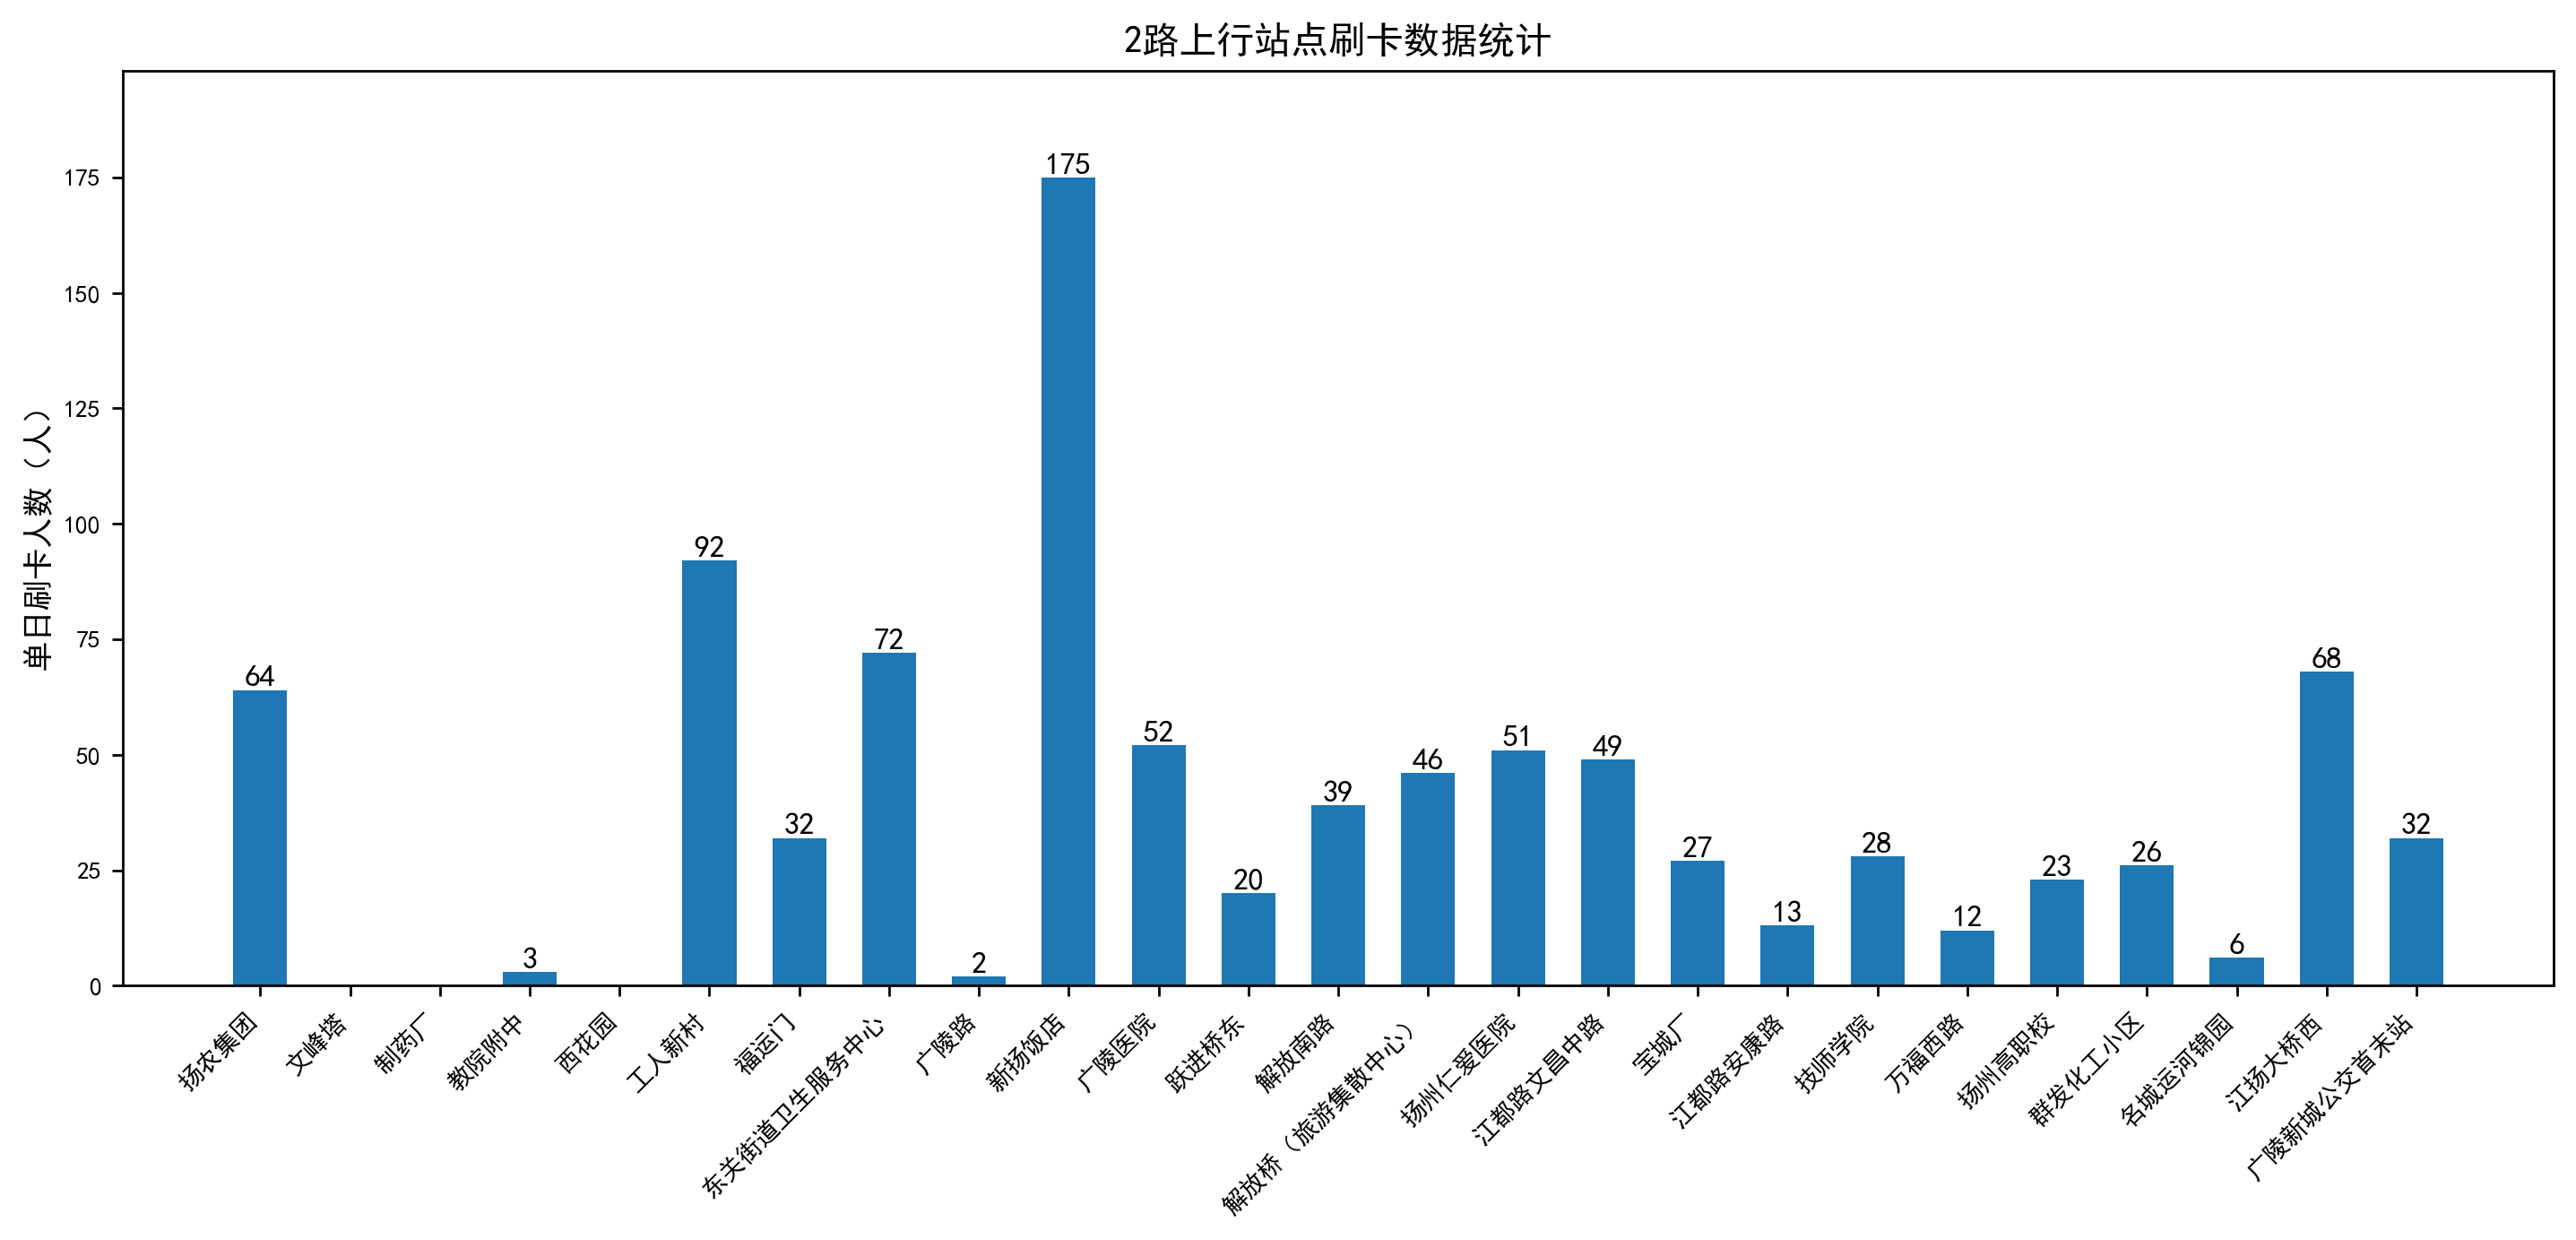

In [20]:
import matplotlib.pyplot as plt
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(14,6),dpi=250)
x_data = shangxingdata['STATIONNAME'].tolist()
y_data = shangxingdata['站点上车人数'].tolist()
ax = plt.gca()
# 为了避免x轴日期刻度标签的重叠，设置x轴刻度自动展现，并且45度倾斜
fig.autofmt_xdate(rotation = 45)
plt.tick_params(labelsize=8)##x轴字体大小
plt.bar(x_data, y_data,width = 0.6)
plt.title(str(xianlumingcheng)+'上行'+'站点刷卡数据统计')
plt.ylabel('单日刷卡人数（人）')
plt.ylim(0,b)
for i,j in zip(x_data,y_data): 
    if j!=0:
        plt.text(i,j,"%d"%j,ha="center",va="bottom")
plt.savefig(os.path.join(r'D:\项目\扬州\公交刷卡数据\上车数量统计\图片\\'+str(xianluid)+'上行.jpg'))
plt.show()

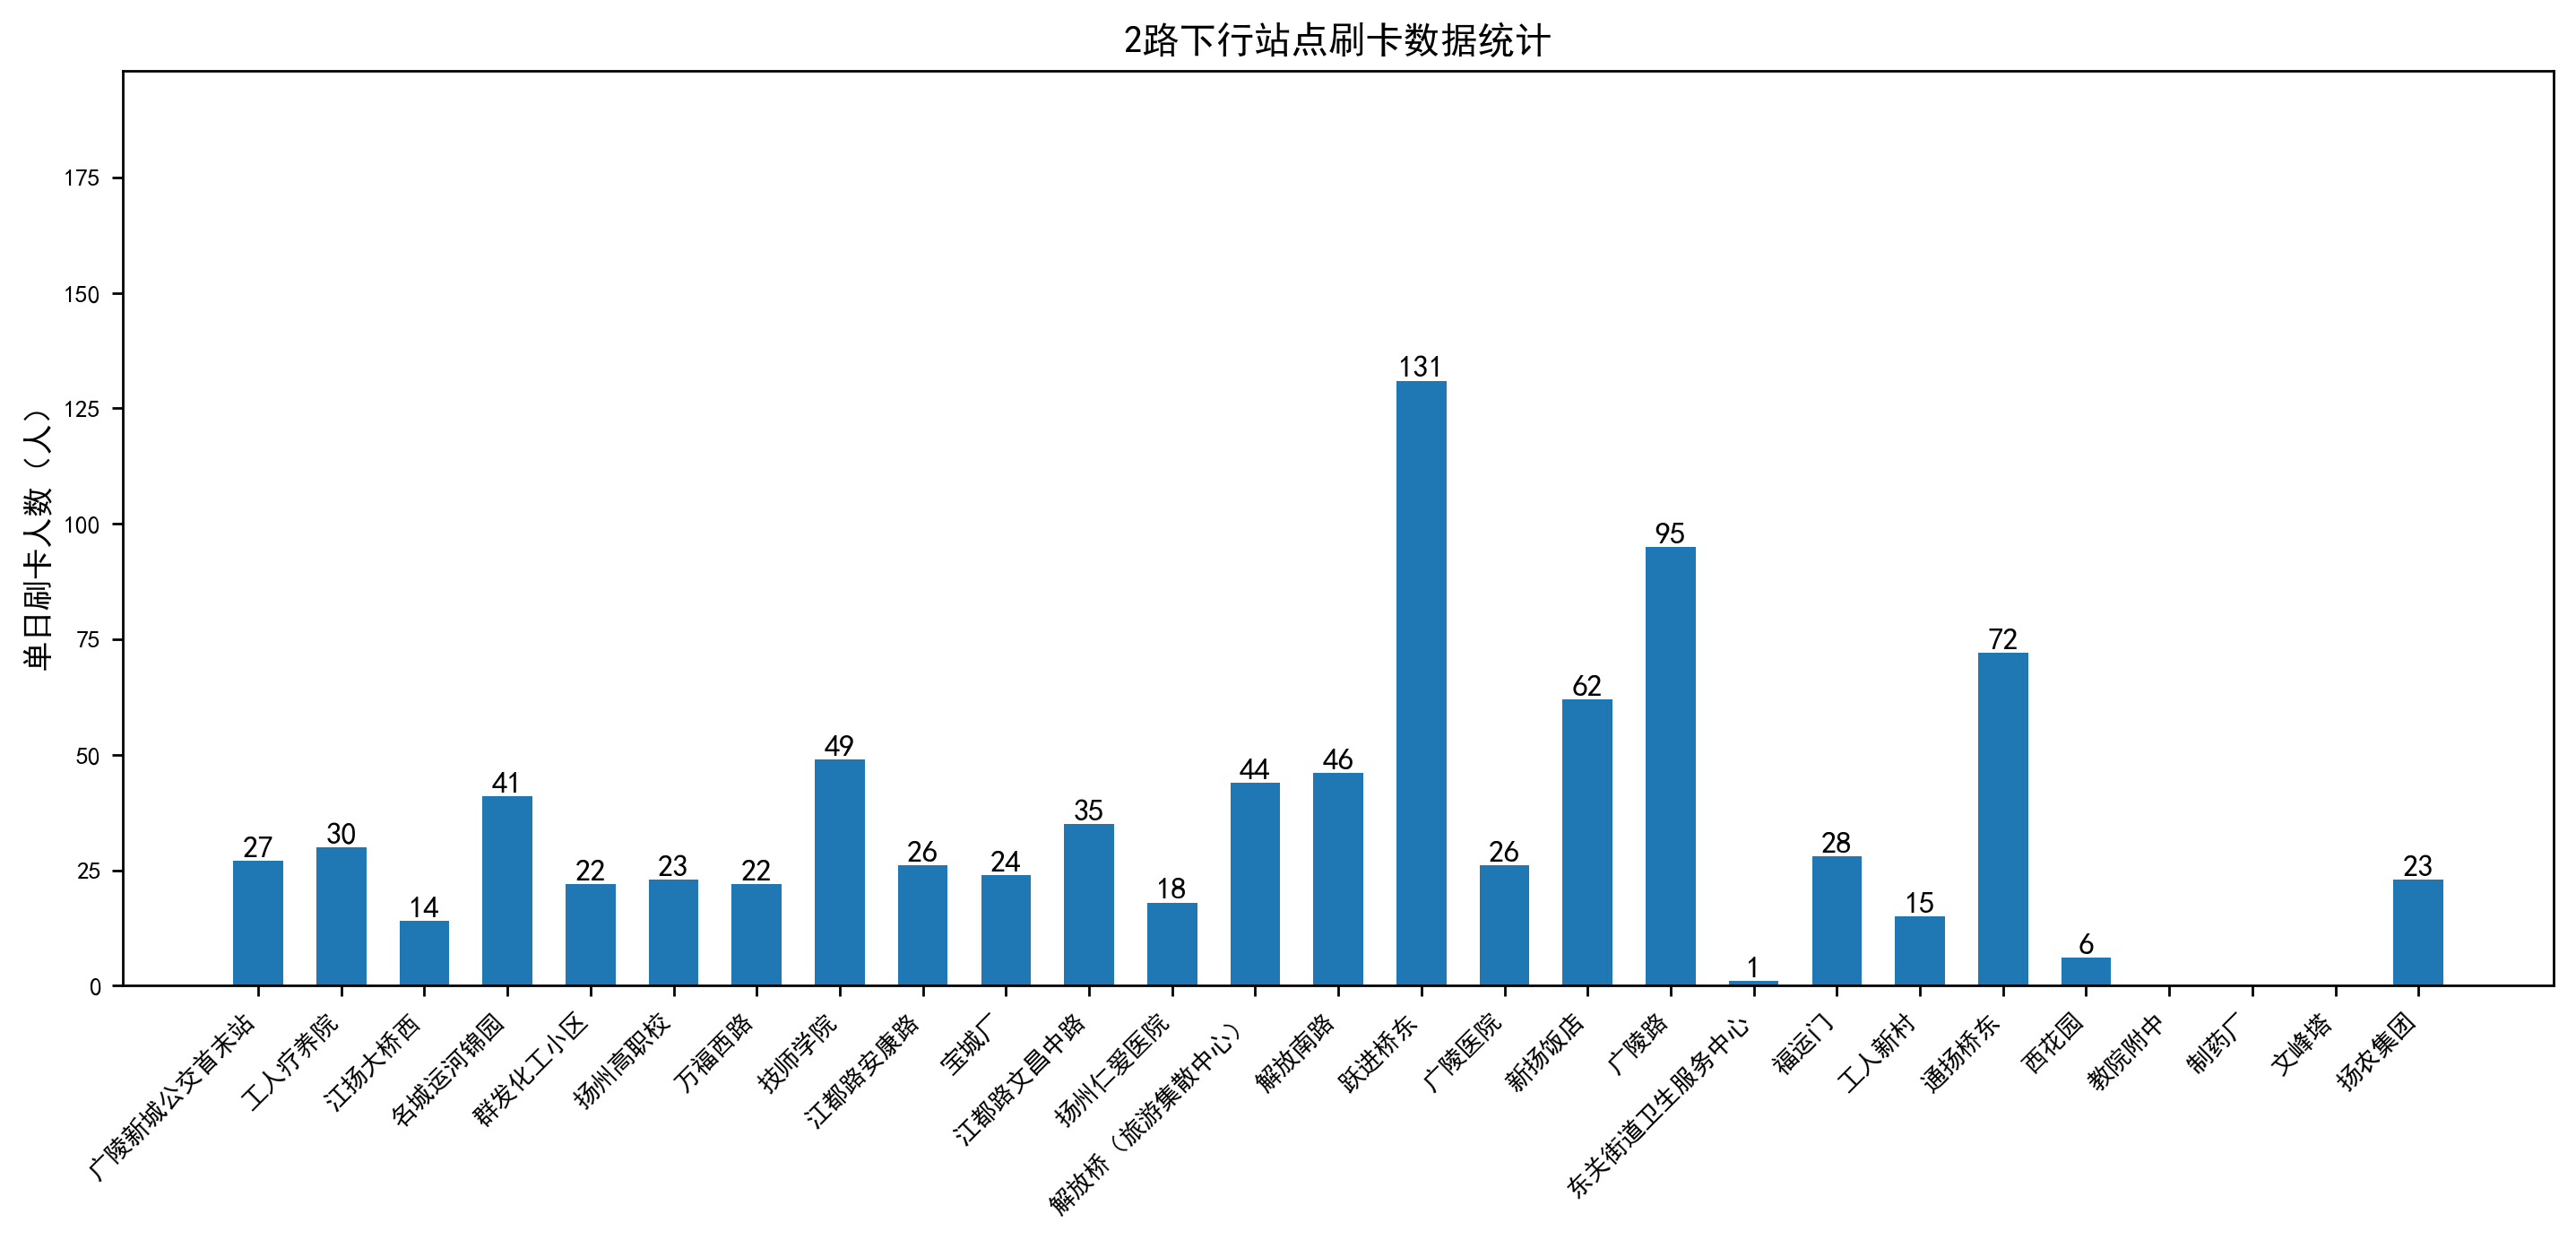

In [21]:
import matplotlib.pyplot as plt
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(14,6),dpi=250)
x_data = xiaxingdata['STATIONNAME'].tolist()
y_data = xiaxingdata['站点上车人数'].tolist()
ax = plt.gca()
# 为了避免x轴日期刻度标签的重叠，设置x轴刻度自动展现，并且45度倾斜
fig.autofmt_xdate(rotation = 45)
plt.tick_params(labelsize=8)##x轴字体大小
plt.bar(x_data, y_data,width = 0.6)
plt.title(str(xianlumingcheng)+'下行'+'站点刷卡数据统计')
plt.ylabel('单日刷卡人数（人）')
plt.ylim(0,b)
for i,j in zip(x_data,y_data): 
    if j!=0:
        plt.text(i,j,"%d"%j,ha="center",va="bottom")
plt.savefig(os.path.join(r'D:\项目\扬州\公交刷卡数据\上车数量统计\图片\\'+str(xianluid)+'下行.jpg'))
plt.show()

In [22]:
yichangjun

23

In [ ]:
##线路核查
cheid2=[]
for cheid in files['文件']:
    #读取GPS数据
    BUS_GPS= pd.read_csv(r'D:\项目\扬州\BUSGPS\车辆编号带线路编号\\'+str(cheid)+'_'+str(routeid)+'.csv',header = None)
    print('len(BUS_GPS)')
    print(len(BUS_GPS))
    if len(BUS_GPS)>10:
        ##提取有用BUS_GPS
        BUS_GPS.columns=BUS_GPS.iloc[0]
        BUS_GPS=BUS_GPS[BUS_GPS['???"BUSRDID"']!='???"BUSRDID"']
        BUS_GPS=BUS_GPS[[ '???"BUSRDID"', 'ROUTEID', 'PRODUCTID', 'ACTDATETIME', 'BUSSID', 'LONGITUDE', 'LATITUDE']]
        ###切分字符串，对BUS_GPS进行进一步处理
        BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/12']
        BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/13']
        BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/14']
        #print(BUS_GPS)
        BUS_GPS['日期'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[0])
        BUS_GPS['时间'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[1])
        BUS_GPS=BUS_GPS.loc[BUS_GPS.日期=='2021/5/13']
        if len(BUS_GPS)>100:
            ##切分bus_gps的车辆编号
            BUS_GPS['PRODUCTID']= BUS_GPS['PRODUCTID'].astype(str)
            BUS_GPS['carid'] = BUS_GPS['PRODUCTID'].apply(lambda r:r.split('5140')[1])
            BUS_GPS['time_st'] = BUS_GPS['时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                            BUS_GPS['时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                            BUS_GPS['时间'].apply(lambda r:r.split(':')[2]).astype('int')
            BUS_GPS.sort_values(by='time_st',inplace=True)
            ##BUS_GPS[BUS_GPS['BUSSID']=='4.0']观察数据，bussid 4下行5上行6环形
            ###生成BUS_GPS的点要素
            #对公交GPS点生成点要素，并转换为一个GeoDataFrame，方便后续的地图匹配
            BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']]= BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']].apply(pd.to_numeric)###字符串转换为数值
            print(BUS_GPS)
            BUS_GPS['geometry'] = BUS_GPS.apply(lambda r:Point(r['LONGITUDE'],r['LATITUDE']),axis = 1)
            BUS_GPS = gpd.GeoDataFrame(BUS_GPS)##转换为一个GeoDataFrame
            BUS_GPS
            xianluid=BUS_GPS['ROUTEID'].iloc[0]
            print('xianluid')
            print(xianluid)
            ##GeoDataFrame坐标转换
            BUS_GPS.crs = {'init':'epsg:4326'}
            BUS_GPS = BUS_GPS.to_crs(epsg = 2416)
            BUS_GPS###至此公交车数据预处理完毕
            ###清除飘零点
            BUS_GPS=BUS_GPS[(BUS_GPS['LONGITUDE']!=0)&(BUS_GPS['LATITUDE']!=0)]
            ###清除不动点
            BUS_GPS['LONGITUDE1'] = BUS_GPS['LONGITUDE'].shift(-1)
            BUS_GPS['不动点']=BUS_GPS['LONGITUDE1']-BUS_GPS['LONGITUDE']
            qq=BUS_GPS['不动点'].unique()
            print(len(qq))
            if len(qq)>100:
                if len(BUS_GPS)>500:
                    BUS_GPS.plot()
                    #地图匹配
                    BUS_GPS['project'] = BUS_GPS['geometry'].apply(lambda r:lineshp.project(r))
                    #原始的坐标点存储在一个字段中
                    BUS_GPS['geometry_orgin'] = BUS_GPS['geometry']
                    #生成匹配的坐标点
                    BUS_GPS['geometry'] = BUS_GPS['project'].apply(lambda r:lineshp.interpolate(r))
                    #批量计算原始点和匹配点之间的距离
                    BUS_GPS['diff'] = BUS_GPS.apply(lambda r:r['geometry_orgin'].distance(r['geometry']),axis = 1)
                    ##轨迹点偏移shp400米以外，则删除
                    BUS_GPS=BUS_GPS[BUS_GPS['diff']<1000]
                    cheid2.append(cheid)
print(cheid2)

In [ ]:
##单车运行图
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
fig     = plt.figure(1,(7,4),dpi = 250)    
ax1      = plt.subplot(111)
tmp=BUS_project
#灰色线标注站点位置
for i in range(len(stop)):
    project = stop['project'].iloc[i]
    stopname = stop['STATIONNAME'].iloc[i]
    plt.plot([0,24*3600],[project,project],'k--',lw=0.1)
    
plt.plot(tmp['time_st'],tmp['project'])

plt.xticks(range(0,24*3600+1,3600),range(24+1))

#标记站点名字
plt.yticks(stop['project'],stop['STATIONNAME'],size = 6)

plt.xlim(6*3600,21*3600)
plt.show()

##全显示不折叠，非常耗内存，非特殊情况不要生效
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
ls2